In [1]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras import layers, optimizers
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
import keras_tuner as kt
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
import shap
import joblib
import time, psutil, os

In [3]:
df = pd.read_csv("/content/combined_dataset.csv")
df

,valid_time,pm1,pm10,pm2p5,bcaod550,aod550,omaod550,tcno2,tcso2,gtco3,tcco,u10,v10,d2m,t2m,sp,blh,tp,ssrd,city
0,2020-01-01 00:00:00,3.345133e-08,5.768080e-08,4.015858e-08,0.007324,0.325636,0.169562,0.000007,0.000004,0.005458,0.001034,-0.359210,0.270797,296.81027,297.75190,99084.750,107.451950,0.000400,1.539016e+05,Jakarta
1,2020-01-01 03:00:00,2.059538e-08,3.735071e-08,2.564554e-08,0.006835,0.349546,0.168343,0.000004,0.000005,0.005518,0.001016,0.884590,-0.294573,295.98276,297.98282,99184.310,557.089360,0.000466,7.752381e+05,Jakarta
2,2020-01-01 06:00:00,1.791439e-08,3.368978e-08,2.290612e-08,0.006645,0.341853,0.150293,0.000002,0.000004,0.005531,0.000990,0.906228,-0.244612,295.98886,299.19520,99048.560,445.996340,0.001658,7.483241e+05,Jakarta
3,2020-01-01 09:00:00,1.998871e-08,3.664903e-08,2.508832e-08,0.006841,0.399741,0.161010,0.000002,0.000004,0.005496,0.000973,-0.222746,0.717506,295.82938,299.81622,98837.810,248.201130,0.000577,6.134947e+05,Jakarta
4,2020-01-01 12:00:00,4.263052e-08,7.215669e-08,5.050946e-08,0.006944,0.342090,0.148887,0.000006,0.000004,0.005465,0.000983,-0.542103,-0.112552,296.41980,298.39337,99058.625,30.429886,0.000662,7.167915e+02,Jakarta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43099,2024-11-30 09:00:00,9.770935e-08,1.613397e-07,1.143496e-07,0.024108,0.590681,0.377568,0.000006,0.000016,0.005727,0.001818,0.796195,-2.069528,282.28564,298.98267,98671.270,1041.326700,0.000000,1.951098e+06,Delhi
43100,2024-11-30 12:00:00,1.998515e-07,3.276284e-07,2.325008e-07,0.025710,0.627246,0.393695,0.000008,0.000017,0.005720,0.001857,2.042600,-1.776162,285.38733,294.98130,98567.600,75.574490,0.000000,1.667239e+05,Delhi
43101,2024-11-30 15:00:00,3.359677e-07,5.503197e-07,3.902109e-07,0.025986,0.645980,0.410317,0.000006,0.000016,0.005697,0.001881,2.276846,0.024371,284.59372,289.50815,98727.610,35.184097,0.000000,0.000000e+00,Delhi
43102,2024-11-30 18:00:00,2.725615e-07,4.481371e-07,3.173912e-07,0.023716,0.595244,0.387847,0.000007,0.000015,0.005670,0.001766,2.021152,-0.741631,283.81998,287.68220,98741.000,38.592712,0.000000,0.000000e+00,Delhi


In [4]:
df['valid_time'] = pd.to_datetime(df['valid_time'])
df = df.sort_values(by=['valid_time', 'city'])

In [5]:
missing_value = 100 * (df.isna().sum() / len(df))
print(missing_value)

valid_time    0.0
pm1           0.0
pm10          0.0
pm2p5         0.0
bcaod550      0.0
aod550        0.0
omaod550      0.0
tcno2         0.0
tcso2         0.0
gtco3         0.0
tcco          0.0
u10           0.0
v10           0.0
d2m           0.0
t2m           0.0
sp            0.0
blh           0.0
tp            0.0
ssrd          0.0
city          0.0
dtype: float64


In [6]:
df['hour'] = df['valid_time'].dt.hour
df['days'] = df['valid_time'].dt.dayofweek
df['month'] = df['valid_time'].dt.month

In [7]:
df = pd.get_dummies(df, columns=['city'])

In [8]:
df['pm2p5'] *= 1e07
df = df.drop(columns=['pm1', 'pm10'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43104 entries, 28736 to 14367
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   valid_time     43104 non-null  datetime64[ns]
 1   pm2p5          43104 non-null  float64       
 2   bcaod550       43104 non-null  float64       
 3   aod550         43104 non-null  float64       
 4   omaod550       43104 non-null  float64       
 5   tcno2          43104 non-null  float64       
 6   tcso2          43104 non-null  float64       
 7   gtco3          43104 non-null  float64       
 8   tcco           43104 non-null  float64       
 9   u10            43104 non-null  float64       
 10  v10            43104 non-null  float64       
 11  d2m            43104 non-null  float64       
 12  t2m            43104 non-null  float64       
 13  sp             43104 non-null  float64       
 14  blh            43104 non-null  float64       
 15  tp             43104

In [10]:
df = df.drop(columns=['valid_time'])

In [11]:
target_col = 'pm2p5'
features_col = [col for col in df.columns if col not in [target_col, 'city', 'city_name', 'datetime']]

In [12]:
data_split = int(len(df) * 0.8)
df_train = df.iloc[:data_split]
df_test = df.iloc[data_split:]

In [13]:
minmax_X = MinMaxScaler()
minmax_y = MinMaxScaler()

X_train = minmax_X.fit_transform(df_train[features_col])
X_test = minmax_X.transform(df_test[features_col])
y_train = minmax_y.fit_transform(df_train[[target_col]])
y_test = minmax_y.transform(df_test[[target_col]])

In [14]:
joblib.dump(minmax_X, 'LSTM_minmax_x.pkl')
joblib.dump(minmax_y, 'LSTM_minmax_y.pkl')

['LSTM_minmax_y.pkl']

In [15]:
def sequence(feature, target, window_size=12):
  X, y = [], []
  for i in range(len(feature) - window_size):
    X.append(feature[i:i+window_size])
    y.append(target[i+window_size])
  return np.array(X), np.array(y)

window = 12
X_train_sq, y_train_sq = sequence(X_train, y_train, window)
X_test_sq, y_test_sq = sequence(X_test, y_test, window)

In [16]:
print(X_train_sq.shape)
print(y_train_sq.shape)
print(X_test_sq.shape)
print(y_test_sq.shape)

(34471, 12, 21)
(34471, 1)
(8609, 12, 21)
(8609, 1)


In [ ]:
model = keras.models.Sequential()

In [ ]:
# First Layer
# 64 = number of memory cells
# return_sequence = giving the
# input_shape = to give the models the expected input data
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train_sq.shape[1], X_train_sq.shape[2])))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.add(layers.LSTM(64, return_sequences=False))

In [ ]:
# 128 = neural network layer with 128 neuron
model.add(layers.Dense(128, activation='relu'))

In [ ]:
# this layer randomly drops 50% of the neuron to prevent overfitting
model.add(layers.Dropout(0.5))

In [ ]:
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

In [ ]:
model.fit(X_train_sq, y_train_sq, epochs=20, batch_size=32)

Epoch 1/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0694 - mean_absolute_error: 0.0694 - root_mean_squared_error: 0.1243
Epoch 2/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0419 - mean_absolute_error: 0.0419 - root_mean_squared_error: 0.0814
Epoch 3/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0754
Epoch 4/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0724
Epoch 5/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0691
Epoch 6/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0669
Epoch 7/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0629
Epoch 8/20
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0

In [ ]:
y_pred_sq = model.predict(X_test_sq)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
y_pred_inversed = minmax_y.inverse_transform(y_pred_sq)
y_pred_real = minmax_y.inverse_transform(y_test_sq)

In [ ]:
print(f"RMSE Score: {root_mean_squared_error(y_pred_real, y_pred_inversed)}")
print(f"MAE Score: {mean_absolute_error(y_pred_real, y_pred_inversed)}")
print(f"R2 Score: {r2_score(y_pred_real, y_pred_inversed)}")

RMSE Score: 0.3509037406641477
MAE Score: 0.17875947954541258
R2 Score: 0.9099347798961253


In [ ]:
model.save("LSTM_base_model.keras")

In [17]:
def LSTM_model_builder(hp):
  model = keras.Sequential()
  model.add(
      layers.LSTM(
          units=hp.Int('unit_1', min_value=32, max_value=256, step=32),
          return_sequences=True,
          input_shape=(X_train_sq.shape[1], X_train_sq.shape[2]),
      )
  )

  for i in range(hp.Int('n_layers', 1, 4)):
    model.add(
        layers.LSTM(
            hp.Int(f"{i} units", min_value=32, max_value=256, step=32),
            return_sequences=True
        )
    )

  model.add(
      layers.LSTM(
          units=hp.Int('unit_2', min_value=32, max_value=256, step=32), return_sequences=False
      )
  )

  model.add(
      layers.Dropout(
            rate = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
      )
  )
  model.add(
      layers.Dense(
          units=hp.Int('dense', min_value=16, max_value=128, step=16),
          activation=hp.Choice('dense_act2', values=['relu', 'linear', 'sigmoid'])
      )
  )

  model.add(
      layers.Dense(
          1,
          activation=hp.Choice('dense_act2', values=['relu', 'linear', 'sigmoid'])
      )
  )

  model.compile(
      optimizer=optimizers.Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4, 1e-4])),
      loss='mae',
      metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
  )

  return model

In [21]:
tunes = kt.RandomSearch(
    LSTM_model_builder,
    objective='mean_absolute_error',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir_retry',
    project_name='LSTM_tuning'
)

Reloading Tuner from tuning_dir_retry/LSTM_tuning/tuner0.json


In [22]:
tunes.search(
    x=X_train_sq,
    y=y_train_sq,
    epochs=40,
    batch_size=64,
)

Trial 10 Complete [00h 05m 55s]
mean_absolute_error: 0.0949392020702362

Best mean_absolute_error So Far: 0.018347369506955147
Total elapsed time: 00h 58m 43s


In [23]:
best_parameter = tunes.get_best_hyperparameters(num_trials=1)[0]

for par in best_parameter.values:
  print(f"{par}: {best_parameter.get(par)}")

unit_1: 192
n_layers: 3
0 units: 128
unit_2: 64
dropout: 0.2
dense: 80
dense_act2: relu
lr: 0.001
1 units: 64
2 units: 96
3 units: 224


In [24]:
best_mod = tunes.hypermodel.build(best_parameter)

In [25]:
best_mod.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 12, 192)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 12, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 12, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,433 (1.86 MB)

 Trainable params: 486,433 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
training_start = time.time()
best_mod.fit(X_train_sq, y_train_sq, epochs=50)
training_end = time.time()

Epoch 1/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0605 - mean_absolute_error: 0.0605 - root_mean_squared_error: 0.1131
Epoch 2/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0412 - mean_absolute_error: 0.0412 - root_mean_squared_error: 0.0780
Epoch 3/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0728
Epoch 4/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - root_mean_squared_error: 0.0714
Epoch 5/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - root_mean_squared_error: 0.0716
Epoch 6/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - root_mean_squared_error: 0.0648
Epoch 7/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - root_mean_squared_error: 0.0639
Epoch 8/50
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step

In [27]:
inference_start = time.time()
y_pred_best = best_mod.predict(X_test_sq)
inference_end = time.time()
y_pred_best_train = best_mod.predict(X_train_sq)

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [28]:
y_train_inverse = minmax_y.inverse_transform(y_train_sq)
y_test_inverse = minmax_y.inverse_transform(y_test_sq)

y_train_pred_inv = minmax_y.inverse_transform(y_pred_best_train.reshape(-1, 1))
y_test_pred_inv = minmax_y.inverse_transform(y_pred_best.reshape(-1, 1))

In [82]:
print("Min:", y_test_sq.min())
print("Smallest non-zero value:", y_test_sq[y_test_sq > 0].min())
print("Median:", np.median(y_test_sq))
print("Mean:", np.mean(y_test_sq))

Min: 0.0
Smallest non-zero value: 1.271564112365386e-07
Median: 0.06940565181697803
Mean: 0.11739119835942327


In [93]:
def fix_mape(y_true, y_pred, epsilon=0.01):
    y_true_safe = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    return mape

In [94]:
epsilons = [1e-6, 1e-4, 1e-3, 1e-2, 0.05, 0.1]
for eps in epsilons:
    mape = fix_mape(y_test_sq, y_pred_best, epsilon=eps)
    print(f"Epsilon = {eps:.6f} → MAPE = {mape:.2f}%")

Epsilon = 0.000001 → MAPE = 949.65%
Epsilon = 0.000100 → MAPE = 49.70%
Epsilon = 0.001000 → MAPE = 30.64%
Epsilon = 0.010000 → MAPE = 22.86%
Epsilon = 0.050000 → MAPE = 14.59%
Epsilon = 0.100000 → MAPE = 11.65%


In [95]:
print("LSTM Test MAPE: ", fix_mape(y_test_sq, y_pred_best))

LSTM Test MAPE:  22.860635194591662


In [96]:
print("LSTM Train MAPE: ", fix_mape(y_train_sq, y_pred_best_train))

LSTM Train MAPE:  18.661273031648758


In [97]:
print("LSTM Best Model Test RMSE Score: ", root_mean_squared_error(y_test_sq, y_pred_best))
print("LSTM Best Model Test MAE Score: ", mean_absolute_error(y_test_sq, y_pred_best))
print("LSTM Best Model Test R2 Score: ", r2_score(y_test_sq, y_pred_best))

LSTM Best Model Test RMSE Score:  0.04259139636519108
LSTM Best Model Test MAE Score:  0.021512811318682497
LSTM Best Model Test R2 Score:  0.9203021705633319


In [98]:
print("LSTM Best Model Train RMSE Score: ", root_mean_squared_error(y_train_sq, y_pred_best_train))
print("LSTM Best Model Train MAE Score: ", mean_absolute_error(y_train_sq, y_pred_best_train))
print("LSTM Best Model Train R2 Score: ", r2_score(y_train_sq, y_pred_best_train))

LSTM Best Model Train RMSE Score:  0.026686151819039154
LSTM Best Model Train MAE Score:  0.014311918994793848
LSTM Best Model Train R2 Score:  0.9690919111202753


In [99]:
best_mod.save('LSTM_best_model.keras')

In [100]:
from tensorflow.keras.models import load_model
best_model = load_model("/content/LSTM_best_model.keras")

In [101]:
def permutation_importance(model, X, y, metric=mean_squared_error):
    baseline = metric(y, model.predict(X))
    importances = []
    for i in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, i])
        score = metric(y, model.predict(X_permuted))
        importances.append(score - baseline)
    return np.array(importances)

In [102]:
importance = permutation_importance(best_model, X_test_sq, y_test_sq)

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [103]:
feature = ['bcaod550', 'omaod550', 'aod550', 'tcco',
       'tcno2', 'gtco3', 'tcso2', 'u10', 'v10', 'd2m', 't2m', 'sp', 'blh',
       'tp', 'ssrd', 'hour', 'days', 'month', 'city_Delhi', 'city_Helsinki',
       'city_Jakarta']

sorted_idx = np.argsort(importance)[::-1]
sorted_importances = importance[sorted_idx]
sorted_features = np.array(feature)[sorted_idx]

greater_than_zero_imp = sorted_importances[sorted_importances > 0]
greater_than_zero_feat = sorted_features[sorted_importances > 0]

top_n = 10
top_importances = greater_than_zero_imp[:top_n]
top_features = greater_than_zero_feat[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances)
plt.yticks(range(len(top_features)), top_features, rotation=45)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("lstm_feature_importance.png", dpi=300, bbox_inches='tight')
plt.close()

In [104]:
from google.colab import files
files.download("lstm_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Addition
1. Extracting the RMSE score based on the city
2. Extracting the Visual Error Analysis
3. Identify the training time and inference time of the LSTM model
4. Identify the memory usage of the LSTM model  

In [123]:
df_test_seq = df.iloc[data_split + window:].copy().reset_index(drop=True)
df_test_seq['y_true'] = y_test_inverse.flatten()
df_test_seq['y_pred'] = y_test_pred_inv.flatten()

In [124]:
city_columns = ['city_Delhi', 'city_Helsinki', 'city_Jakarta']
df_test_seq['city'] = df_test_seq[city_columns].idxmax(axis=1).str.replace('city_', '')

In [122]:
city_rmse = df_test_seq.groupby('city').apply(lambda g: root_mean_squared_error(g['y_true'], g['y_pred']))
city_rmse

/tmp/ipython-input-122-168276946.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_rmse = df_test_seq.groupby('city').apply(lambda g: root_mean_squared_error(g['y_true'], g['y_pred']))


,0
city,
Delhi,0.553354
Helsinki,0.052730
Jakarta,0.134039


In [125]:
training_time = training_end - training_start
inference_time = inference_end - inference_start
memory = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

In [126]:
print("Training Time (s): ", training_time)
print("Inference Time (s): ", inference_time)
print("Memory Used: ", memory)

Training Time (s):  907.4608359336853
Inference Time (s):  1.7679274082183838
Memory Used:  2081.68359375


In [127]:
error_df = pd.DataFrame({
    'True_PM2.5': y_test_inverse.flatten(),
    'Predicted_PM2.5': y_test_pred_inv.flatten()
})

In [128]:
error_df['Residual'] = error_df['True_PM2.5'] - error_df['Predicted_PM2.5']

In [129]:
threshold_95 = error_df['True_PM2.5'].quantile(0.95)

In [130]:
error_df['Outlier_Label'] = np.where(error_df['True_PM2.5'] >= threshold_95, 'Outlier', 'Non-Outlier')

In [131]:
error_df['True_PM2.5_Scaled'] = error_df['True_PM2.5'] * 1e7

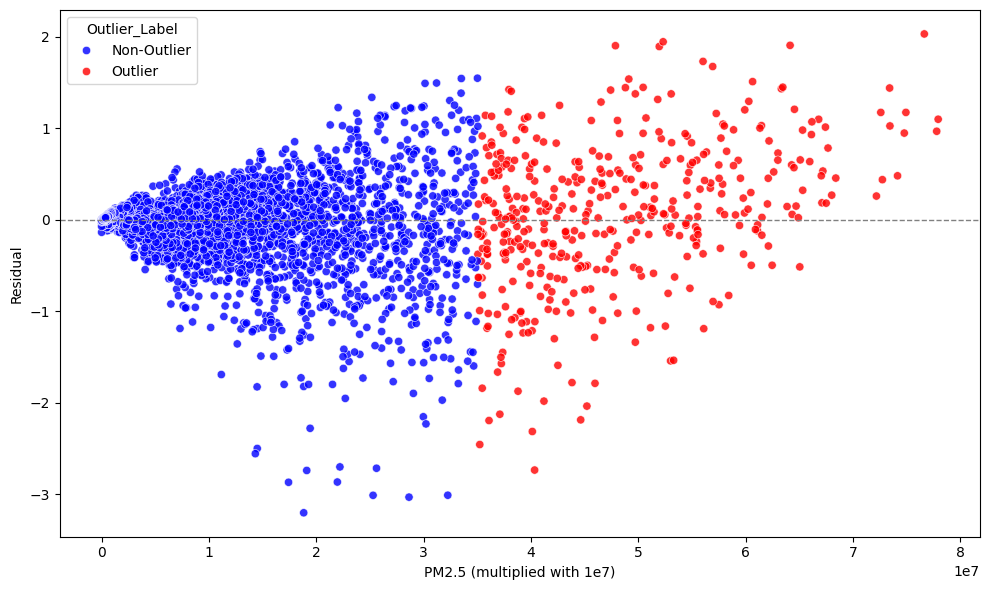

In [135]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=error_df, x='True_PM2.5_Scaled', y='Residual',
                hue='Outlier_Label', palette={'Non-Outlier': 'blue', 'Outlier': 'red'}, alpha=0.8)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("PM2.5 (multiplied with 1e7)")
plt.ylabel("Residual")
plt.legend(title='Outlier_Label')
plt.tight_layout()
plt.savefig("LSTM_Residual_Visual_Error_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()